# RECAP: Foundations of Graph Neural Networks

In this notebook, we will explore the fundamental concepts behind Graph Neural Networks (GNNs), with a specific focus on Graph Convolutional Networks (GCNs) as introduced in the seminal paper "Semi-Supervised Classification with Graph Convolutional Networks" by Thomas Kipf and Max Welling (2017).

## Learning Objectives

By the end of this notebook, you should understand:
1. Basic graph theory concepts
2. The motivation for GNNs and semi-supervised learning on graphs
3. Spectral graph convolutions and their approximations
4. Practical implementation of basic graph operations

Let's begin by importing the necessary libraries.

In [1]:
import numpy as np
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os
import sys

# Add the current directory to path for importing utils
sys.path.append('.')
import utils

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 1. Basic Graph Theory Concepts

A **graph** is a mathematical structure consisting of a set of **nodes** (or vertices) and a set of **edges** that connect pairs of nodes. Formally, a graph $G$ is defined as $G = (V, E)$, where $V$ is the set of nodes and $E$ is the set of edges.

### Types of Graphs

1. **Directed Graph (Digraph)**: Edges have a direction, meaning that an edge from node $u$ to node $v$ doesn't imply an edge from $v$ to $u$.
2. **Undirected Graph**: Edges have no direction. If nodes $u$ and $v$ are connected, they are connected in both directions.
3. **Weighted Graph**: Edges have associated weights, often representing distances, costs, or strengths of connections.
4. **Unweighted Graph**: All edges have the same weight (typically treated as 1).

### Graph Representations

There are several ways to represent a graph in computer memory. The most common representations are:

1. **Adjacency Matrix**: A square matrix where element $(i,j)$ indicates whether nodes $i$ and $j$ are connected.
2. **Adjacency List**: For each node, store a list of its neighboring nodes.
3. **Edge List**: Store a list of all edges in the graph.

Let's create a simple undirected graph and explore these representations:

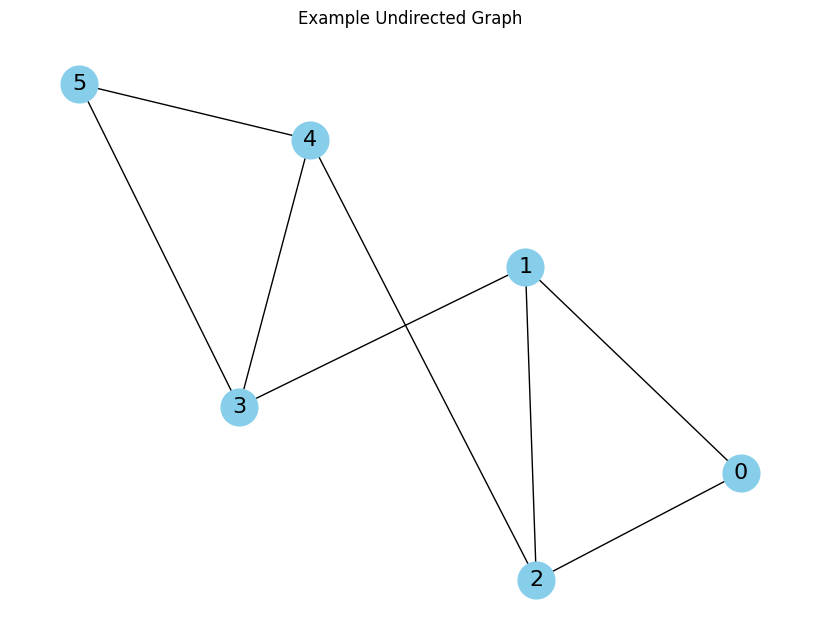

Adjacency Matrix:
[[0 1 1 0 0 0]
 [1 0 1 1 0 0]
 [1 1 0 0 1 0]
 [0 1 0 0 1 1]
 [0 0 1 1 0 1]
 [0 0 0 1 1 0]]

Adjacency List:
Node 0 -> [1, 2]
Node 1 -> [0, 2, 3]
Node 2 -> [0, 1, 4]
Node 3 -> [1, 4, 5]
Node 4 -> [2, 3, 5]
Node 5 -> [3, 4]

Edge List:
[(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 5)]


In [2]:
# Create a simple undirected graph using NetworkX
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 5)])

# Visualize the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, font_size=16)
plt.title("Example Undirected Graph")
plt.show()

# Get the adjacency matrix
A = nx.adjacency_matrix(G).toarray()
print("Adjacency Matrix:")
print(A)

# Get the adjacency list
adj_list = dict(G.adjacency())
print("\nAdjacency List:")
for node, neighbors in adj_list.items():
    print(f"Node {node} -> {list(neighbors.keys())}")

# Get the edge list
edge_list = list(G.edges())
print("\nEdge List:")
print(edge_list)

### Node Degree and Graph Laplacian

The **degree** of a node is the number of edges connected to it. For an undirected graph, the degree matrix $D$ is a diagonal matrix where $D_{ii}$ is the degree of node $i$.

The **graph Laplacian** $L$ is defined as $L = D - A$, where $A$ is the adjacency matrix. The normalized Laplacian is defined as $L_{sym} = D^{-1/2}LD^{-1/2} = I - D^{-1/2}AD^{-1/2}$, where $I$ is the identity matrix.

The graph Laplacian has many important properties and is central to spectral graph theory.

In [3]:
# Calculate degree matrix
degrees = np.sum(A, axis=1)
D = np.diag(degrees)
print("Degree Matrix:")
print(D)

# Calculate graph Laplacian
L = D - A
print("\nGraph Laplacian:")
print(L)

# Calculate normalized Laplacian
D_inv_sqrt = np.diag(np.power(degrees, -0.5))
L_sym = np.eye(len(D)) - D_inv_sqrt @ A @ D_inv_sqrt
print("\nNormalized Laplacian:")
print(np.round(L_sym, 3))

Degree Matrix:
[[2 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 2]]

Graph Laplacian:
[[ 2 -1 -1  0  0  0]
 [-1  3 -1 -1  0  0]
 [-1 -1  3  0 -1  0]
 [ 0 -1  0  3 -1 -1]
 [ 0  0 -1 -1  3 -1]
 [ 0  0  0 -1 -1  2]]

Normalized Laplacian:
[[ 1.    -0.408 -0.408  0.     0.     0.   ]
 [-0.408  1.    -0.333 -0.333  0.     0.   ]
 [-0.408 -0.333  1.     0.    -0.333  0.   ]
 [ 0.    -0.333  0.     1.    -0.333 -0.408]
 [ 0.     0.    -0.333 -0.333  1.    -0.408]
 [ 0.     0.     0.    -0.408 -0.408  1.   ]]


## 2. Motivation for GNNs and Semi-Supervised Learning on Graphs

### Why Graph Neural Networks?

Many real-world data can naturally be represented as graphs:
- Social networks (users as nodes, friendships as edges)
- Citation networks (papers as nodes, citations as edges)
- Protein-protein interaction networks
- Knowledge graphs
- Molecular structures

Traditional deep learning methods (like CNNs, RNNs) are designed for data with regular structures (grids, sequences), but they struggle with graph-structured data because:

1. Graphs can have arbitrary sizes and structures
2. There's no natural ordering of nodes
3. The same graph can be represented with different node orderings

GNNs address these challenges by operating directly on the graph structure.

### What is Semi-Supervised Learning?

In many real-world scenarios, labeled data is scarce while unlabeled data is abundant. Semi-supervised learning aims to leverage both labeled and unlabeled data for training.

On graphs, semi-supervised learning is particularly natural because:
- Only a few nodes may have labels
- The graph structure provides a way to propagate information from labeled to unlabeled nodes
- Connected nodes tend to have similar properties (homophily)

Let's look at a toy example of semi-supervised learning on a graph:

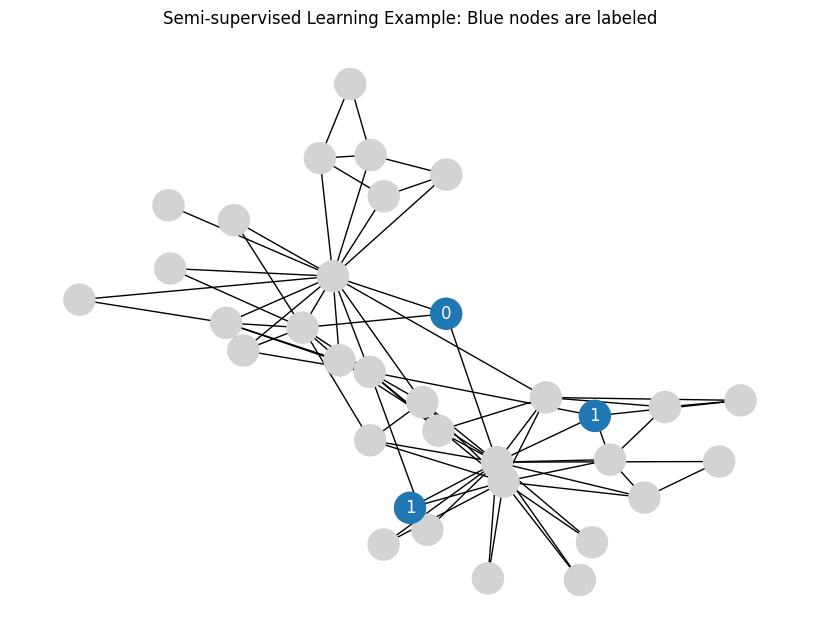

Total nodes: 34, Labeled nodes: 3


In [4]:
# Create a larger graph with community structure
G = nx.karate_club_graph()  # Zachary's Karate Club graph, a standard example

# Get ground truth communities
# In real-world settings, we would only have labels for a few nodes
ground_truth = [0 if G.nodes[i]['club'] == 'Mr. Hi' else 1 for i in G.nodes]

# Let's pretend we only have labels for 10% of the nodes
num_nodes = len(G.nodes)
num_labeled = int(0.1 * num_nodes)  # 10% labeled nodes
labeled_indices = np.random.choice(num_nodes, num_labeled, replace=False)
node_colors = ['#1f77b4' if i in labeled_indices else 'lightgrey' for i in range(num_nodes)]

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=node_colors, node_size=500)

# Draw the ground truth labels for labeled nodes
labels = {i: ground_truth[i] if i in labeled_indices else '' for i in range(num_nodes)}
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_color='white')

plt.title("Semi-supervised Learning Example: Blue nodes are labeled")
plt.show()

print(f"Total nodes: {num_nodes}, Labeled nodes: {num_labeled}")

## 3. Spectral Graph Convolutions

Now, let's delve into the theoretical foundations of Graph Convolutional Networks.

### Convolution in the Euclidean Domain vs. Graph Domain

In traditional Convolutional Neural Networks (CNNs), convolution is defined in the Euclidean domain (grids). It involves sliding a filter over the input and computing the dot product.

For graphs, we can't directly apply this approach because:
1. Nodes can have different numbers of neighbors
2. There's no clear notion of "sliding a filter"

Therefore, graph convolutions are typically defined in the spectral domain using the graph Laplacian.

### Spectral Graph Theory Basics

The normalized graph Laplacian $L_{sym} = I - D^{-1/2}AD^{-1/2}$ has several important properties:
- It's a real symmetric positive semi-definite matrix
- It can be decomposed as $L_{sym} = U \Lambda U^T$, where $U$ contains the eigenvectors and $\Lambda$ is a diagonal matrix of eigenvalues
- The eigenvectors form an orthonormal basis

The graph Fourier transform of a signal $x$ is defined as $\hat{x} = U^T x$, and the inverse transform is $x = U\hat{x}$.

### Spectral Graph Convolution

The convolution of a signal $x$ with a filter $g$ in the spectral domain is defined as:
$g * x = Ug_\theta(\Lambda)U^T x$

where $g_\theta(\Lambda)$ is a function of the eigenvalues.

This operation is computationally expensive because it requires the eigendecomposition of the Laplacian.

### Approximations in GCN

Kipf and Welling (2017) used several approximations to make the spectral convolution more efficient:

1. They used a specific filter function: $g_\theta(\Lambda) = \theta_0 + \theta_1 \Lambda + ... + \theta_K \Lambda^K$
2. They truncated it to the first-order approximation ($K=1$): $g_\theta(\Lambda) \approx \theta_0 + \theta_1 \Lambda$
3. They further constrained $\theta = \theta_0 = -\theta_1$ to address overfitting
4. They reparameterized with $\tilde{A} = A + I$ (adding self-loops) and $\tilde{D}_{ii} = \sum_j \tilde{A}_{ij}$

This led to the simplified GCN layer:
$H^{(l+1)} = \sigma(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)})$

where $H^{(l)}$ is the activations at layer $l$, $W^{(l)}$ is the weight matrix, and $\sigma$ is a non-linear activation function.

This form has a nice interpretation: each node aggregates features from its neighbors, with appropriate normalization.

Let's implement the renormalization trick:

In [5]:
def preprocess_adj(adj):
    """
    Preprocessing of adjacency matrix for GCN model:
    - Add self-loops
    - Apply symmetric normalization
    
    Parameters
    ----------
    adj : numpy.ndarray or scipy.sparse matrix
        Adjacency matrix
        
    Returns
    -------
    numpy.ndarray
        Preprocessed adjacency matrix
    """
    # Convert to numpy array if it's not already
    if sp.issparse(adj):
        adj = adj.toarray()
    
    # Add self-loops
    adj_with_self_loops = adj + np.eye(adj.shape[0])
    
    # Calculate degree matrix
    degrees = np.sum(adj_with_self_loops, axis=1)
    
    # Calculate D^(-1/2)
    D_inv_sqrt = np.diag(np.power(degrees, -0.5))
    
    # Calculate D^(-1/2) A D^(-1/2)
    normalized_adj = D_inv_sqrt @ adj_with_self_loops @ D_inv_sqrt
    
    return normalized_adj

# Test the function on our example graph
normalized_adj = preprocess_adj(A)
print("Original adjacency matrix:")
print(A)
print("\nPreprocessed adjacency matrix:")
print(np.round(normalized_adj, 3))

Original adjacency matrix:
[[0 1 1 0 0 0]
 [1 0 1 1 0 0]
 [1 1 0 0 1 0]
 [0 1 0 0 1 1]
 [0 0 1 1 0 1]
 [0 0 0 1 1 0]]

Preprocessed adjacency matrix:
[[0.333 0.289 0.289 0.    0.    0.   ]
 [0.289 0.25  0.25  0.25  0.    0.   ]
 [0.289 0.25  0.25  0.    0.25  0.   ]
 [0.    0.25  0.    0.25  0.25  0.289]
 [0.    0.    0.25  0.25  0.25  0.289]
 [0.    0.    0.    0.289 0.289 0.333]]


## 4. Implementing Basic Graph Operations

Now let's implement some basic graph operations that will be useful for our GCN implementation. We'll load a citation network dataset (Cora) and apply the graph preprocessing techniques we've learned.

In [6]:
# Load the Cora dataset
adj, features, labels, idx_train, idx_val, idx_test = utils.load_data(dataset="cora")

print(f"Adjacency matrix shape: {adj.shape}")
print(f"Feature matrix shape: {features.shape}")
print(f"Number of classes: {len(np.unique(labels))}")
print(f"Training samples: {len(idx_train)}")
print(f"Validation samples: {len(idx_val)}")
print(f"Test samples: {len(idx_test)}")

Download completed!
Adjacency matrix shape: (2708, 2708)
Feature matrix shape: (2708, 1433)
Number of classes: 7
Training samples: 140
Validation samples: 500
Test samples: 1000


In [8]:
# Preprocess adjacency matrix for GCN
def preprocess_adj_sparse(adj):
    """
    Preprocessing of adjacency matrix for GCN model with sparse matrices
    """
    adj_normalized = utils.normalize_adj(adj + sp.eye(adj.shape[0]))
    return adj_normalized

# Preprocess features
def preprocess_features(features):
    """
    Row-normalize feature matrix
    """
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features

# Preprocess adjacency and feature matrices
adj_normalized = preprocess_adj_sparse(adj)
features_normalized = preprocess_features(features)

print(f"Normalized adjacency matrix shape: {adj_normalized.shape}")
print(f"Normalized feature matrix shape: {features_normalized.shape}")
print(f"Normalized adjacency matrix nnz (non-zeros): {adj_normalized.nnz}")
print(f"Normalized feature matrix nnz (non-zeros): {features_normalized.nnz}")

Normalized adjacency matrix shape: (2708, 2708)
Normalized feature matrix shape: (2708, 1433)
Normalized adjacency matrix nnz (non-zeros): 13264
Normalized feature matrix nnz (non-zeros): 49216


## 5. Summary and Next Steps

In this notebook, we've covered the foundational concepts for understanding Graph Convolutional Networks:

1. **Basic Graph Theory**: Nodes, edges, adjacency matrices, and the graph Laplacian
2. **Motivation for GNNs**: Why traditional deep learning methods struggle with graph-structured data
3. **Semi-Supervised Learning on Graphs**: Leveraging both labeled and unlabeled data
4. **Spectral Graph Convolutions**: The theoretical foundation of GCNs and their approximations
5. **Basic Graph Operations**: Loading and preprocessing graph data

In the next notebook, we'll implement the GCN layer and build a complete GCN model from scratch using PyTorch.

## Questions for Understanding

1. Why can't we directly apply traditional CNNs to graph-structured data?
2. What is the role of the graph Laplacian in spectral graph convolutions?
3. Explain the renormalization trick in the GCN paper. Why is it important?
4. How does semi-supervised learning on graphs leverage the graph structure?
5. What are some real-world applications where representing data as a graph would be beneficial?